# Practical Four: Panoramas (Features, Matching, Transform, and Stitch)

This notebook is prepared to introduce you to the basics of how to create image panoramas including finding keypoints in an image, describing those key points, matching them to those points in another image, computing the transform from one image to the other, and stitching them together into a panorama.


### References
* [Based on "Homework 2: Panoramas!"](https://github.com/pjreddie/vision-hw2)
* [Lecture 6: Features and Matching](https://docs.google.com/presentation/d/11f77YuX5YVUmhr1QWYGCSmg5lHyml0VaRjDh93aceHI/edit?usp=sharing) and [Lecture 7: Matching, RANSAC, SIFT, and HoG](https://docs.google.com/presentation/d/1QgLpO6-fOn14dGbyPXidGolOEX6G3yFZc3UAXeALnek/edit?usp=sharing)

## Load Required Modules

In [184]:
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
import numpy as np
import matplotlib.pyplot as pl

In [185]:
def np2img(im, norm=False, rgb_mode=False):
    """
    This function converts the input numpy object im to Image object and returns
    the converted object. If norm == True, then the input is normalised to [0,1]
    using im <- (im - im.min()) / (im.max() - im.min()).
    """
    if norm:
        if ((im.max() - im.min()) != 0.0):
            im = (im - im.min()) / (im.max() - im.min())

    if ((im.min() >= 0.0) and (im.max() <= 1.0)):
        im = im * 255.0

    if rgb_mode and im.ndim == 2:
        im = im[...,np.newaxis].repeat(3, axis=2)
        
    if im.ndim == 2:
        im = Image.fromarray(im.astype(np.uint8), mode='L')
    elif (im.ndim == 3) and (im.shape[2] == 3):
        im = Image.fromarray(im.astype(np.uint8), mode='RGB')

    return im

def draw_corners(im, points, line_length=7, line_width=1, color=(255, 0, 0)):
    """
    This function draws a cross at each point (x,y) of the input points list 
    on the input image object im.
    """
    im = im.copy()
    draw = ImageDraw.Draw(im)
    for point in points:
        x, y = point[0], point[1]
        
        if ((x-line_length) >= 0):
            left = ((x-line_length), y)
        else:
            left = (0, y)
        
        if ((x+line_length) < im.size[0]):
            right = ((x+line_length), y)
        else:
            right = (im.size[0]-1, y)

        if ((y-line_length) >= 0):
            top = (x, (y-line_length))
        else:
            top = (x, 0)

        if ((y+line_length) < im.size[1]):
            bottom = (x, (y+line_length))
        else:
            bottom = (x, im.size[1]-1)
        
        draw.line(left + right, fill=color, width=line_width)
        draw.line(top + bottom, fill=color, width=line_width)

    return im

def imresize_nn(im, width, height, img_obj=False):
    """
    This function resizes the input Image object im to the size of (width x height)
    pixels based on the nearest neigbor interpolation and returns the resized Image object.
    """
    # Convert the input Image object to numpy array object
    im = np.array(im).astype(float)
    if (im.shape[0] == height) and (im.shape[1] == width):
        im_res = im.copy()
    else:
        # Create an empty array of (height x width) pixels
        if im.ndim == 2:
            im_res = np.zeros((height, width))
        else:
            im_res = np.zeros((height, width, im.shape[2]))

        # Match up coordinates using (x_res, y_res) -> (x_im, y_im), i.e.,
        # a_x * x_res + b_x = x_im
        # a_y * y_res + b_y = y_im
        a_x = ((im.shape[1] - 0.5) - (-0.5)) / ((im_res.shape[1] - 0.5) - (-0.5))
        b_x = (-0.5) - a_x * (-0.5)
        a_y = ((im.shape[0] - 0.5) - (-0.5)) / ((im_res.shape[0] - 0.5) - (-0.5))
        b_y = (-0.5) - a_y * (-0.5)

        # Create a lookup table for speeding up the operations
        y_im = np.zeros(im_res.shape[0], dtype=np.int32)
        for i in range(im_res.shape[0]):
            y_im[i] = int(np.round(a_y * i + b_y))
            if y_im[i] < 0:
                y_im[i] = 0
            if y_im[i] > (im.shape[0] - 1):
                y_im[i] = im.shape[0] - 1

        x_im = np.zeros(im_res.shape[1], dtype=np.int32)
        for i in range(im_res.shape[1]):
            x_im[i] = int(np.round(a_x * i + b_x))
            if x_im[i] < 0:
                x_im[i] = 0
            if x_im[i] > (im.shape[1] - 1):
                x_im[i] = im.shape[1] - 1
        # Iterate over new points
        for y in range(im_res.shape[0]):
            for x in range(im_res.shape[1]):
                im_res[y, x] = im[y_im[y], x_im[x]]

    if img_obj:
        im_res = np2img(im_res)

    return im_res


def imresize_bi(im, width, height, img_obj=False):
    """
    This function resizes the input Image object im to the size of (width x height) 
    pixels based on the bilinear interpolation and returns the resized Image object.
    """
    # Convert the input Image object to numpy array object

    im = np.array(im).astype(float)
    if (im.shape[0] == height) and (im.shape[1] == width):
        im_res = im.copy()
    else:
        # Create an empty array of (height x width) pixels
        if im.ndim == 2:
            im_res = np.zeros((height, width))
        else:
            im_res = np.zeros((height, width, im.shape[2]))

        # Match up coordinates using (x_res, y_res) -> (x_im, y_im), i.e.,
        # a_x * x_res + b_x = x_im
        # a_y * y_res + b_y = y_im
        a_x = ((im.shape[1]-0.5) - (-0.5)) / ((im_res.shape[1]-0.5) - (-0.5))
        b_x = (-0.5) - a_x * (-0.5)
        
        a_y = ((im.shape[0]-0.5) - (-0.5)) / ((im_res.shape[0]-0.5) - (-0.5))
        b_y = (-0.5) - a_y * (-0.5)
        
        # Create a lookup table for speeding up the operations
        y_im = np.zeros((im_res.shape[0], 2), dtype=np.int32)
        y_im_d = np.zeros((im_res.shape[0], 2), dtype=np.float32)
        for i in range(im_res.shape[0]):
            y_im_ = a_y * i + b_y
            # Take care of the boundary cases
            if y_im_ < 0.0:
                y_im_ = np.abs(y_im_)
            if y_im_ > (im.shape[0]-1):
                y_im_ = (im.shape[0]-1) - (y_im_-(im.shape[0]-1))
            # Compute the mapping in the input image coordinate
            y_im[i,0] = int(np.floor(y_im_))
            y_im[i,1] = int(np.ceil(y_im_))
            y_im_d[i,0] = y_im[i,1] - y_im_
            y_im_d[i,1] = y_im_ - y_im[i,0]
            

        x_im = np.zeros((im_res.shape[1], 2), dtype=np.int32)
        x_im_d = np.zeros((im_res.shape[1], 2), dtype=np.float32)
        for i in range(im_res.shape[1]):
            x_im_ = a_x * i + b_x
            # Take care of the boundary cases
            if x_im_ < 0.0:
                x_im_ = np.abs(x_im_)
            if x_im_ > (im.shape[1]-1):
                x_im_ = (im.shape[1]-1) - (x_im_-(im.shape[1]-1))
            # Compute the mapping in the input image coordinate
            x_im[i,0] = int(np.floor(x_im_))
            x_im[i,1] = int(np.ceil(x_im_))
            x_im_d[i,0] = x_im[i,1] - x_im_
            x_im_d[i,1] = x_im_ - x_im[i,0]
        
        # Iterate over new points
        for y in range(im_res.shape[0]):
            for x in range(im_res.shape[1]):
                if (x_im[x,0] == x_im[x,1]) and (y_im[y,0] == y_im[y,1]):
                    q = im[y_im[y,0], x_im[x,0]]
                elif (x_im[x,0] == x_im[x,1]):
                    v1 = im[y_im[y,0], x_im[x,0]]
                    v3 = im[y_im[y,1], x_im[x,1]]
                    q = v1 * y_im_d[y,0] + v3 * y_im_d[y,1]
                elif (y_im[y,0] == y_im[y,1]):
                    v1 = im[y_im[y,0], x_im[x,0]]
                    v2 = im[y_im[y,1], x_im[x,1]]
                    q = v1 * x_im_d[x,0] + v2 * x_im_d[x,1]
                else:
                    v1 = im[y_im[y,0], x_im[x,0]]
                    v2 = im[y_im[y,0], x_im[x,1]]
                    v3 = im[y_im[y,1], x_im[x,0]]
                    v4 = im[y_im[y,1], x_im[x,1]]
                    q1 = v1 * x_im_d[x,0] + v2 * x_im_d[x,1]
                    q2 = v3 * x_im_d[x,0] + v4 * x_im_d[x,1]
                    q = q1 * y_im_d[y,0] + q2 * y_im_d[y,1]
    
                im_res[y, x] = q

    if img_obj:
        im_res = np2img(im_res)
    
    return im_res


def imfilter(im, filter, preserve=False, img_obj=False, mode='edge'):
    """
    This function filters the input object im with the numpy array filter and 
    returns the filtered image object.
    """
    # Convert the input object to numpy array object
    im = np.array(im).astype(float)
    if (im.ndim == 2):
        im = im[...,np.newaxis]
    # Get the filter dimensions
    h, w = filter.shape[:2][0] // 2, filter.shape[:2][1] // 2
    if (filter.ndim == 2):
        filter = filter[...,np.newaxis]
    # Apply padding on the input image to handle image boundaries
    pad_width = [[h,h],[w,w]]
    for d in range(2, im.ndim):
        pad_width.append([0,0])
    im = np.pad(im, pad_width=pad_width, mode=mode)
    # Create place holder for the filtered image
    if preserve:
        im_ = im.copy()
        # Iterate over pixels
        for y in range(h, im.shape[0]-h):
            for x in range(w, im.shape[1]-w):
                im_[y,x] = (im[y-h:y+h+1, x-w:x+w+1] * filter).sum(axis=(0,1))
    else:
        im_ = np.zeros(im.shape[:2])
        # Iterate over pixels
        for y in range(h, im.shape[0]-h):
            for x in range(w, im.shape[1]-w):
                im_[y,x] = (im[y-h:y+h+1, x-w:x+w+1] * filter).sum()

    # Exclude the boundary pixels
    im = im_[h:im.shape[0]-h, w:im.shape[1]-w]

    if img_obj:
        im = np2img(im)
    
    return im


def box_filter(width, height, channel=1):
    """
    This function creates and returns a numpy array of size (height x width) with all entries equal to 1/(height x width x channel). 
    If any of input parameters width and height is an even number, then it is rolled up to the nearest
    odd number. Note that if channel > 1, then the returned array will be of dimensions (height x width x channel).
    """
    if (width % 2) == 0:
        width += 1
    if (height % 2) == 0:
        height += 1

    if channel > 1:
        data = np.ones((height, width, channel)) / (height * width * channel)
    else:
        data = np.ones((height, width)) / (height * width)

    return data


def gaussian_kernel(sigma, dim=1):
    """
    This function generates and returns either a 1D (dim=1) or 2D (dim=2)
    Gaussian kernel with a standard deviation sigma. Note that the function
    automatically adjusts the kernel size so that 99% of the distribution falls 
    within 3 standard deviations.
    """
    k = int(2 * np.ceil(3*sigma) + 1)
    x = np.linspace(-3*sigma, 3*sigma, k)
    g = 1.0 / np.sqrt(2 * np.pi * sigma**2) * np.exp(-x**2/(2*sigma**2))
    g = g / g.sum()
    g = g[np.newaxis,...]
    if dim == 2:
        g = np.dot(g.T, g)
        
    return g


def detect_corners(im, sigma=1, thresh=0.1, alpha=0.06, w=5):
    """
    This function detects and returns the spatial locations of the corners in the 
    input 2D image object im using the Harris corner detection pipeline. See above for 
    the definitions of the parameters.
    """
    B = gaussian_kernel(sigma=1.0, dim=2)
    G = gaussian_kernel(sigma, dim=2)
    Sx = np.array([[1.0, 0.0, -1.0], [2.0, 0.0, -2.0], [1.0, 0.0, -1.0]])
    Sy = Sx.copy().T
    # Blur image
    IB = imfilter(im, B)
    # Calculate image derivatives
    Ix = imfilter(IB, Sx)
    Iy = imfilter(IB, Sy)
    # Calculate three measures
    IxIx = Ix * Ix
    IyIy = Iy * Iy
    IxIy = Ix * Iy
    # Calculate three measures with weighted sums
    IxIx = imfilter(IxIx, G)
    IyIy = imfilter(IyIy, G)
    IxIy = imfilter(IxIy, G)
    # Calculate cornerness response
    R = (IxIx * IyIy - IxIy**2) - alpha * (IxIx + IyIy)**2
    # Apply non-maximum suppression and find the list of corners
    # w = 5
    w = w // 2
    w = 1 if w == 0 else w
    keypoints = []
    for y in range(w, R.shape[0]-w):
        for x in range(w, R.shape[1]-w):
            if R[y,x] >= thresh:
                if (R[y-w:y+w+1,x-w:x+w+1] > R[y,x]).sum() == 0:
                    keypoints.append([x,y])
    
    return np.array(keypoints)


def describe_corners(im, keypoints, w=5):
    """
    This function returns a descriptor for each input corner based on its w x w neighborhood on the input image objec im.
    """
    im = np.array(im).astype(float)
    w = w // 2
    w = 1 if w == 0 else w
    b = np.zeros((2*w+1, 2*w+1), dtype=np.int8)
    b[w, w] = 1
    b = (b == 0)
    descriptors = []
    for keypoint in keypoints:
        descriptor = im[keypoint[1]-w:keypoint[1]+w+1, keypoint[0]-w:keypoint[0]+w+1]
        descriptor = descriptor - im[keypoint[1],keypoint[0]]
        descriptors.append(descriptor[b].flatten())

    return np.array(descriptors)

def descriptor_distance(d1, d2, distance_type='L2'):
    """
    This function computes and returns distance between the 1D vector d1 and 2D array d2.
    """
    distance = []
    if distance_type == 'L2':
        distance = np.sqrt(((d2 - d1)**2).sum(axis=1))
    elif distance_type == 'L1':
        distance = np.abs(d2 - d1).sum(axis=1)

    return distance

def match_descriptors(descriptors1, descriptors2, distance_type='L2'):
    """
    This function matches each descriptor of descriptors1 with the closest descriptor in descriptors2.
    """
    matches = []
    distances = []
    for i, descriptor1 in enumerate(descriptors1):
        distance = descriptor_distance(descriptor1, descriptors2, distance_type=distance_type)
        j = np.argmin(distance)
        matches.append([i, j])
        distances.append(distance[j])
    
    matches = np.array(matches)
    distances = np.array(distances)

    return matches, distances

def find_and_draw_matches(im1, im2, sigma=1, thresh=0.1, 
    alpha=0.06, w=5, distance_type='L2', 
    line_width=1, line_color=(0, 128, 0), cross_color=(0,0,128), text_color=(255,0,0)):
    """
    This function finds and draws best matches between the keypoints of im1 and im2.
    It ensures one-to-one keypoint matches. It returns an image showing the one-to-one
    matching and the corresponding keypoint coordinates as a list.
    """
    F = np.array([[[0.299, 0.587, 0.114]]])
    I1 = imfilter(im1, F) / 255.0
    I2 = imfilter(im2, F) / 255.0

    keypoints1 = detect_corners(I1, sigma=sigma, thresh=thresh, alpha=alpha, w=w)
    keypoints2 = detect_corners(I2, sigma=sigma, thresh=thresh, alpha=alpha, w=w)

    descriptors1 = describe_corners(im1, keypoints1, w=w)
    descriptors2 = describe_corners(im2, keypoints2, w=w)

    matches, distances = match_descriptors(descriptors1, descriptors2, distance_type=distance_type)
    indexes = np.argsort(distances)
    matches_ = []
    keypoints2_ = []
    for index in indexes:
        if matches[index,1] not in keypoints2_:
            keypoints2_.append(matches[index,1])
            matches_.append(matches[index].tolist())  
    matches = np.array(matches_)
    
    im12 = Image.new('RGB', (im1.width + im2.width, max(im1.height, im2.height)), color=(255, 255, 255))
    im12.paste(draw_corners(im1,keypoints1,line_width=line_width,color=cross_color), (0, 0))
    im12.paste(draw_corners(im2,keypoints2,line_width=line_width,color=cross_color), (im1.width, 0))
    draw = ImageDraw.Draw(im12)
    keypoints12 = []
    for i, match in enumerate(matches):
        keypoint1 = keypoints1[match[0]]
        keypoint2 = keypoints2[match[1]]
        keypoints12.append({'keypoint1':keypoint1,'keypoint2':keypoint2})
        keypoint2 += np.array([im1.width, 0])
        draw.line(keypoint1.tolist() + keypoint2.tolist(), fill=line_color, width=line_width)
        draw.text(keypoint1.tolist(), str(i), fill=text_color)
        draw.text(keypoint2.tolist(), str(i), fill=text_color)

    return im12, keypoints12

## Harris Corner (Keypoint) Detector, Corner (Keypoint) Descriptor, and Corner (Keypoint) Matching

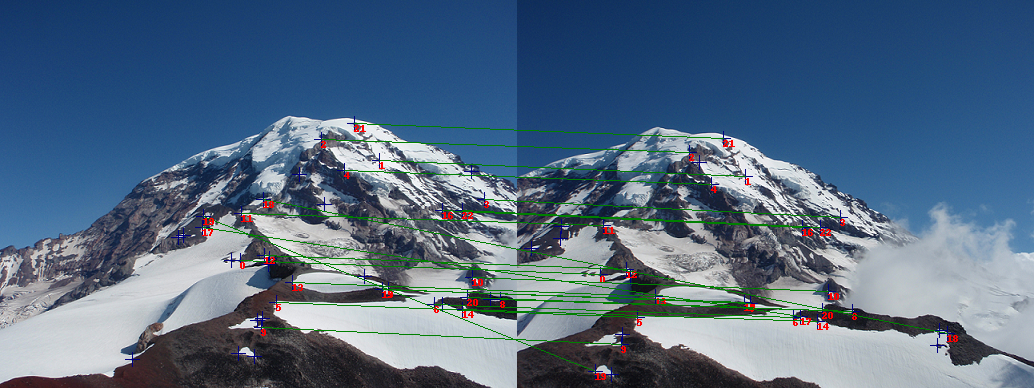

In [186]:
sigma = 1.0
thresh = 0.15
alpha = 0.06
w = 7
distance_type = 'L1'
im1 = Image.open('../data/Rainier1.png').convert('RGB')
im2 = Image.open('../data/Rainier2.png').convert('RGB')
im12, keypoints12  = find_and_draw_matches(im1, im2, sigma, thresh, alpha, w, distance_type)
display(im12)

## Panorama Algorithm

You will remember from your lecture notes that the panorama algorithm is comprised of the following steps:
1) Find corners (keypoints) in both images;
2) Compute corner (keypoint) descriptors;
3) Match descriptors;
4) Apply RANSAC to find the homography transformation using the matched keypoints; and
5) Stitch together two images with the homography transformation.


You will remember from your lecture notes that the panorama algorithm is comprised of the following steps:
1) Find corners (keypoints) in both images;
2) Compute corner (keypoint) descriptors;
3) Match descriptors;
4) Apply RANSAC to find the homography transformation using the matched keypoints; and
5) Stitch together two images with the homography transformation.

You have already implemented the Step 1-3 of the panorama algorithm. I have slightly modified the function `find_and_draw_matches(...)` also to return the coordinates of the best keypoint matches between the input images as a list, e.g., `keypoints12` in the following code snipped:

```
sigma = 1.0
thresh = 0.15
alpha = 0.06
w = 7
distance_type = 'L1'
im1 = Image.open('../data/Rainier1.png').convert('RGB')
im2 = Image.open('../data/Rainier2.png').convert('RGB')
im12, keypoints12  = find_and_draw_matches(im1, im2, sigma, thresh, alpha, w, distance_type)
display(im12)
```

Note that each element `keypoint12` of `keypoints12` is a dictionary holding the spatial coordinates of the matched keypoints as a two-element array in the format of $(x,y)$, i.e., `keypoint12['keypoint1']` and `keypoint12['keypoint2']`.

### Projective (Homography) Transformation of a 2D Point

For a given homography matrix $\mathbf{H} = \left[ \begin{matrix} h_{00} & h_{01} & h_{02} \\ h_{10} & h_{11} & h_{12} \\ h_{20} & h_{21} & 1\end{matrix} \right]$, the projective transformation would transform a point $\mathbf{p}_{i} = (x_{i},y_{i})$ to $\mathbf{p}^{\prime}_{i} = (x^{\prime}_{i},y^{\prime}_{i})$ according to $x^{\prime}_{i} = {(h_{00} x + h_{01} y + h_{02})} / {(h_{20} x + h_{21} y + 1)}$ and $y^{\prime}_{i} = {(h_{10} x + h_{11} y + h_{12})} / {(h_{20} x + h_{21} y + 1)}$.

The function `project_point(H, p)` applies the projective transformation to the input point `p` based on the homography matrix `H` and returns the projected point.

In [187]:
def project_point(H, p):
    """
    This function applies the projective transformation to the input point p
    based on the homography matrix H and returns the projected point.
    """
    p = np.hstack((p, 1.0))
    p_ = np.dot(H, p)
    if p_[-1] != 0.0:
        p_ = p_ / p_[-1]
    return p_[:-1]

Let's apply an arbitrary projective transformation on a 2D quadrilateral object, just because we can :).

In [188]:
# Create an arbitrary rectangle from four 2D points 
points = np.array([[0,0],[1,0],[1,1],[0,1]])
# Create an arbitrary homography
np.random.seed(7)
H = np.random.rand(3,3)
H[2,2] = 1.0

Text(0.5, 1.0, 'Projected 2D Quadrilateral')

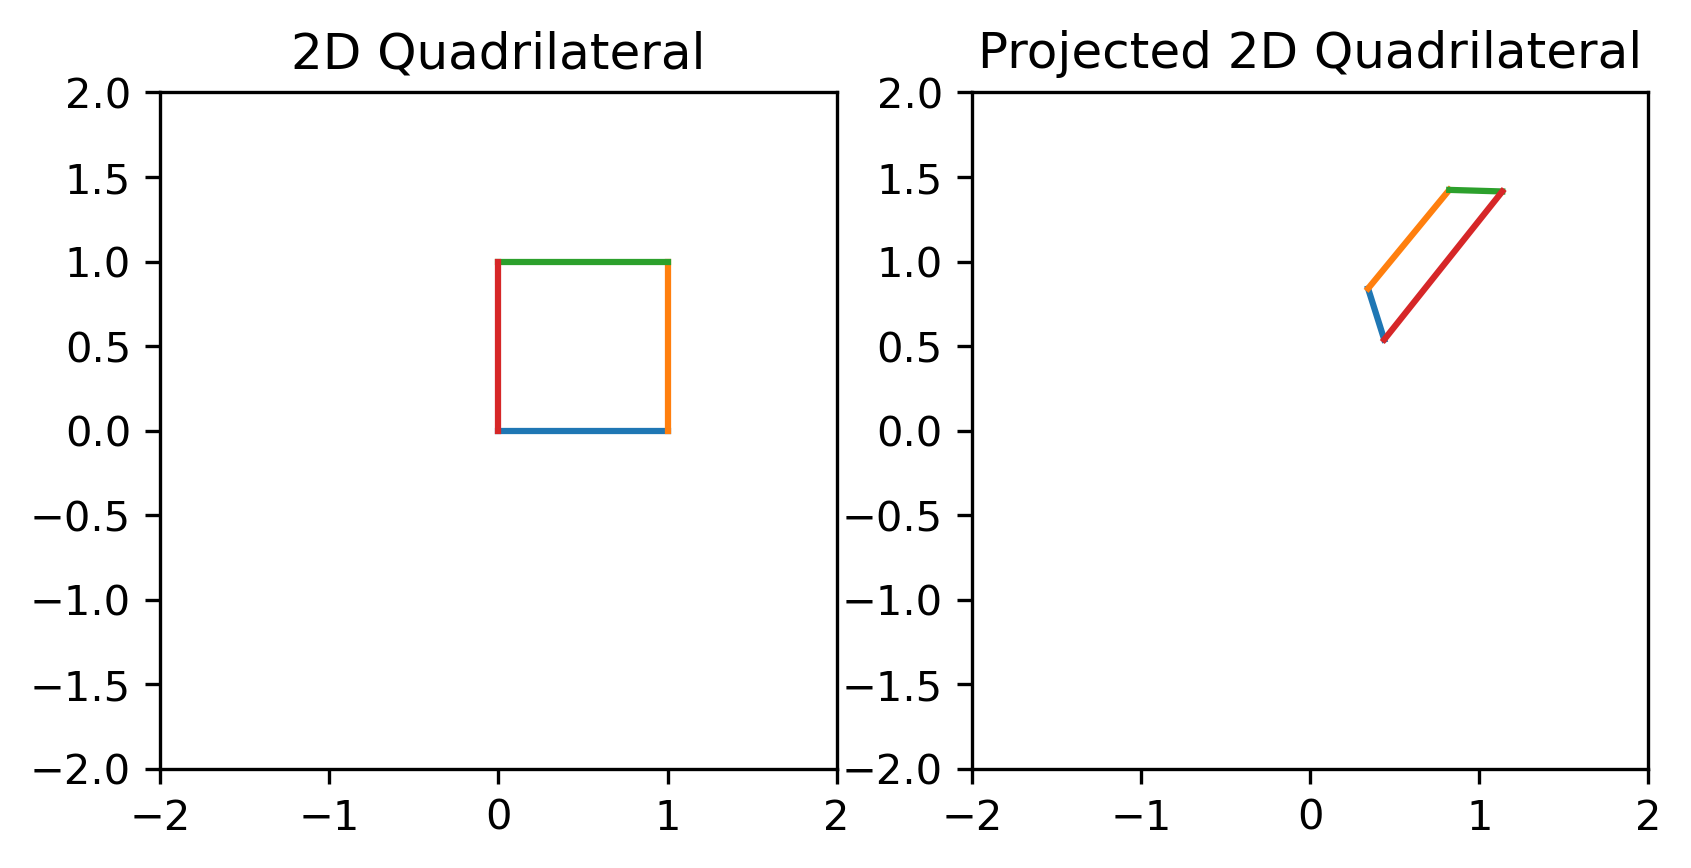

In [189]:

fig, axs = pl.subplots(1,2, dpi=300)
for i in range(points.shape[0]):
    point1 = points[i]
    point2 = points[((i+1) % points.shape[0])]
    points12 = np.vstack((point1, point2))
    axs[0].plot(points12[:,0], points12[:,1])

    point1 = project_point(H, points[i])
    point2 = project_point(H, points[((i+1) % points.shape[0])])
    points12 = np.vstack((point1, point2))
    axs[1].plot(points12[:,0], points12[:,1])

axs[0].set_aspect('equal', 'box')
axs[0].set_xlim(-2, 2)
axs[0].set_ylim(-2, 2)
axs[0].set_title('2D Quadrilateral')
axs[1].set_aspect('equal', 'box')
axs[1].set_xlim(-2, 2)
axs[1].set_ylim(-2, 2)
axs[1].set_title('Projected 2D Quadrilateral')

### Calculate Distances Between 2D Points

For given two 2D points $\mathbf{p}$ and $\mathbf{q}$, the function `point_distance(p,q)` computes and returns the `L2` distance between the input 1D arrays `p` and `q`.

In [190]:
def point_distance(p,q):
    """
    Computes and returns the L2 distance between the input 1D arrays p and q.
    """    
    distance = np.sqrt(np.sum((p-q)**2))
    
    return distance

### Calculate Model Inliers


#### Your Task [20 Marks]

Our model is a homography $\mathbf{H}$ which projects keypoints from the first image to the second image using the function `project_point(...)`. We asses the quality of a good model $\mathbf{H}$ based on the number of inliers to it. Complete the function `model_inliers(H, keypoints12, thresh)` to loop over the matched keypoints between two images, project keypoints of the first image to the second one using the homography, check if the projected keypoints is within some threshold distance `thresh` of the actual matching keypoint in the other image, and return the number of inliers. Also, we want to bring inliers to the front of the list `keypoints12`. This helps us later on with the fitting functions. This should all be doable in one pass through the data.

In [191]:
def model_inliers(H, keypoints12, thresh):
    inliers_count = 0
    inliers_indices = []  # Keep track of indices of inliers

    # Loop over the matched keypoints and project each from the first image to the second
    for i, keypoint in enumerate(keypoints12):
        keypoint1 = keypoint['keypoint1']
        keypoint2 = keypoint['keypoint2']
        keypoint1_projected = project_point(H, keypoint1)  # Assume project_point is defined elsewhere
        
        # Calculate the Euclidean distance between the projected point and the actual point in the second image
        distance = np.linalg.norm(np.array(keypoint1_projected) - np.array(keypoint2))
        
        if distance < thresh:  # If within threshold, treat as an inlier
            inliers_count += 1
            inliers_indices.append(i)  # Add index to inliers_indices if within threshold

    # Reconstruct the keypoints list with inliers at the front
    reordered_keypoints = [keypoints12[i] for i in inliers_indices] + [keypoints12[i] for i in range(len(keypoints12)) if i not in inliers_indices]
    inliers_list = [keypoints12[i] for i in inliers_indices]

    return inliers_count, inliers_list, reordered_keypoints


After you complete the implementation of `model_inliers(...)`, the following code snippet
```
inliers_count, inliers_list, keypoints12_ = model_inliers(H, keypoints12, 700)
display(inliers_count)
display(keypoints12)
display(keypoints12_)
display(inliers_list)
```
should be able to produce the output:
```
4
[{'keypoint1': array([240, 260]), 'keypoint2': array([600, 274])},
 {'keypoint1': array([379, 160]), 'keypoint2': array([745, 176])},
 {'keypoint1': array([321, 139]), 'keypoint2': array([689, 152])},
 {'keypoint1': array([484, 199]), 'keypoint2': array([840, 217])},
 {'keypoint1': array([344, 170]), 'keypoint2': array([711, 184])},
 {'keypoint1': array([276, 302]), 'keypoint2': array([637, 317])},
 {'keypoint1': array([434, 304]), 'keypoint2': array([793, 317])},
 {'keypoint1': array([388, 289]), 'keypoint2': array([750, 303])},
 {'keypoint1': array([500, 299]), 'keypoint2': array([852, 311])},
 {'keypoint1': array([261, 327]), 'keypoint2': array([621, 344])},
 {'keypoint1': array([472, 277]), 'keypoint2': array([828, 291])},
 {'keypoint1': array([241, 213]), 'keypoint2': array([603, 225])},
 {'keypoint1': array([264, 255]), 'keypoint2': array([626, 269])},
 {'keypoint1': array([292, 282]), 'keypoint2': array([655, 296])},
 {'keypoint1': array([462, 309]), 'keypoint2': array([817, 321])},
 {'keypoint1': array([382, 289]), 'keypoint2': array([744, 302])},
 {'keypoint1': array([442, 210]), 'keypoint2': array([802, 227])},
 {'keypoint1': array([202, 227]), 'keypoint2': array([800, 316])},
 {'keypoint1': array([263, 199]), 'keypoint2': array([947, 333])},
 {'keypoint1': array([203, 216]), 'keypoint2': array([595, 371])},
 {'keypoint1': array([467, 297]), 'keypoint2': array([822, 310])},
 {'keypoint1': array([354, 123]), 'keypoint2': array([723, 138])},
 {'keypoint1': array([462, 210]), 'keypoint2': array([820, 227])}]
[{'keypoint1': array([241, 213]), 'keypoint2': array([603, 225])},
 {'keypoint1': array([240, 260]), 'keypoint2': array([600, 274])},
 {'keypoint1': array([264, 255]), 'keypoint2': array([626, 269])},
 {'keypoint1': array([203, 216]), 'keypoint2': array([595, 371])},
 {'keypoint1': array([321, 139]), 'keypoint2': array([689, 152])},
 {'keypoint1': array([261, 327]), 'keypoint2': array([621, 344])},
 {'keypoint1': array([276, 302]), 'keypoint2': array([637, 317])},
 {'keypoint1': array([292, 282]), 'keypoint2': array([655, 296])},
 {'keypoint1': array([344, 170]), 'keypoint2': array([711, 184])},
 {'keypoint1': array([354, 123]), 'keypoint2': array([723, 138])},
 {'keypoint1': array([379, 160]), 'keypoint2': array([745, 176])},
 {'keypoint1': array([382, 289]), 'keypoint2': array([744, 302])},
 {'keypoint1': array([388, 289]), 'keypoint2': array([750, 303])},
 {'keypoint1': array([442, 210]), 'keypoint2': array([802, 227])},
 {'keypoint1': array([462, 210]), 'keypoint2': array([820, 227])},
 {'keypoint1': array([434, 304]), 'keypoint2': array([793, 317])},
 {'keypoint1': array([202, 227]), 'keypoint2': array([800, 316])},
 {'keypoint1': array([484, 199]), 'keypoint2': array([840, 217])},
 {'keypoint1': array([462, 309]), 'keypoint2': array([817, 321])},
 {'keypoint1': array([472, 277]), 'keypoint2': array([828, 291])},
 {'keypoint1': array([467, 297]), 'keypoint2': array([822, 310])},
 {'keypoint1': array([500, 299]), 'keypoint2': array([852, 311])},
 {'keypoint1': array([263, 199]), 'keypoint2': array([947, 333])}]
[{'keypoint1': array([241, 213]), 'keypoint2': array([603, 225])},
 {'keypoint1': array([240, 260]), 'keypoint2': array([600, 274])},
 {'keypoint1': array([264, 255]), 'keypoint2': array([626, 269])},
 {'keypoint1': array([203, 216]), 'keypoint2': array([595, 371])}]
```

In [192]:
inliers_count, inliers_list, keypoints12_ = model_inliers(H, keypoints12, 700)
display(inliers_count)
display(keypoints12)
display(keypoints12_)
display(inliers_list)

4

[{'keypoint1': array([240, 260]), 'keypoint2': array([600, 274])},
 {'keypoint1': array([379, 160]), 'keypoint2': array([745, 176])},
 {'keypoint1': array([321, 139]), 'keypoint2': array([689, 152])},
 {'keypoint1': array([484, 199]), 'keypoint2': array([840, 217])},
 {'keypoint1': array([344, 170]), 'keypoint2': array([711, 184])},
 {'keypoint1': array([276, 302]), 'keypoint2': array([637, 317])},
 {'keypoint1': array([434, 304]), 'keypoint2': array([793, 317])},
 {'keypoint1': array([388, 289]), 'keypoint2': array([750, 303])},
 {'keypoint1': array([500, 299]), 'keypoint2': array([852, 311])},
 {'keypoint1': array([261, 327]), 'keypoint2': array([621, 344])},
 {'keypoint1': array([472, 277]), 'keypoint2': array([828, 291])},
 {'keypoint1': array([241, 213]), 'keypoint2': array([603, 225])},
 {'keypoint1': array([264, 255]), 'keypoint2': array([626, 269])},
 {'keypoint1': array([292, 282]), 'keypoint2': array([655, 296])},
 {'keypoint1': array([462, 309]), 'keypoint2': array([817, 321

[{'keypoint1': array([240, 260]), 'keypoint2': array([600, 274])},
 {'keypoint1': array([241, 213]), 'keypoint2': array([603, 225])},
 {'keypoint1': array([264, 255]), 'keypoint2': array([626, 269])},
 {'keypoint1': array([203, 216]), 'keypoint2': array([595, 371])},
 {'keypoint1': array([379, 160]), 'keypoint2': array([745, 176])},
 {'keypoint1': array([321, 139]), 'keypoint2': array([689, 152])},
 {'keypoint1': array([484, 199]), 'keypoint2': array([840, 217])},
 {'keypoint1': array([344, 170]), 'keypoint2': array([711, 184])},
 {'keypoint1': array([276, 302]), 'keypoint2': array([637, 317])},
 {'keypoint1': array([434, 304]), 'keypoint2': array([793, 317])},
 {'keypoint1': array([388, 289]), 'keypoint2': array([750, 303])},
 {'keypoint1': array([500, 299]), 'keypoint2': array([852, 311])},
 {'keypoint1': array([261, 327]), 'keypoint2': array([621, 344])},
 {'keypoint1': array([472, 277]), 'keypoint2': array([828, 291])},
 {'keypoint1': array([292, 282]), 'keypoint2': array([655, 296

[{'keypoint1': array([240, 260]), 'keypoint2': array([600, 274])},
 {'keypoint1': array([241, 213]), 'keypoint2': array([603, 225])},
 {'keypoint1': array([264, 255]), 'keypoint2': array([626, 269])},
 {'keypoint1': array([203, 216]), 'keypoint2': array([595, 371])}]

### Randomize the List of Keypoint Matches

#### Your Task [10 Marks]

One of the steps in RANSAC is drawing random matches to estimate a new model. One easy way to do this is randomly shuffle the array of keypoint matches and then take the first adequate number of elements to fit a model. Implement the [Fisher-Yates shuffle](https://en.wikipedia.org/wiki/Fisher%E2%80%93Yates_shuffle#The_modern_algorithm) in `randomize_matches(keypoints12)` to return shuffled version of the input `keypoints12`. 

In [193]:
def randomize_matches(keypoints12):
    '''
    Shuffles the input list according Fisher-Yates algorithm and returns
    shuffled list.
    '''
    keypoints12_ = keypoints12.copy()
    
    #COMPLETE HERE
    for i in range(len(keypoints12_)):
        j = np.random.randint(i, len(keypoints12_))
        keypoints12_[i], keypoints12_[j] = keypoints12_[j], keypoints12_[i]
    
    return keypoints12_

After you complete the implementation of `randomize_matches(...)`, the following code snippet
```
np.random.seed(7)
keypoints12_ = randomize_matches(keypoints12)
display(keypoints12)
display(keypoints12_)
```
should be able to produce the output:
```
[{'keypoint1': array([240, 260]), 'keypoint2': array([600, 274])},
 {'keypoint1': array([379, 160]), 'keypoint2': array([745, 176])},
 {'keypoint1': array([321, 139]), 'keypoint2': array([689, 152])},
 {'keypoint1': array([484, 199]), 'keypoint2': array([840, 217])},
 {'keypoint1': array([344, 170]), 'keypoint2': array([711, 184])},
 {'keypoint1': array([276, 302]), 'keypoint2': array([637, 317])},
 {'keypoint1': array([434, 304]), 'keypoint2': array([793, 317])},
 {'keypoint1': array([388, 289]), 'keypoint2': array([750, 303])},
 {'keypoint1': array([500, 299]), 'keypoint2': array([852, 311])},
 {'keypoint1': array([261, 327]), 'keypoint2': array([621, 344])},
 {'keypoint1': array([472, 277]), 'keypoint2': array([828, 291])},
 {'keypoint1': array([241, 213]), 'keypoint2': array([603, 225])},
 {'keypoint1': array([264, 255]), 'keypoint2': array([626, 269])},
 {'keypoint1': array([292, 282]), 'keypoint2': array([655, 296])},
 {'keypoint1': array([462, 309]), 'keypoint2': array([817, 321])},
 {'keypoint1': array([382, 289]), 'keypoint2': array([744, 302])},
 {'keypoint1': array([442, 210]), 'keypoint2': array([802, 227])},
 {'keypoint1': array([202, 227]), 'keypoint2': array([800, 316])},
 {'keypoint1': array([263, 199]), 'keypoint2': array([947, 333])},
 {'keypoint1': array([203, 216]), 'keypoint2': array([595, 371])},
 {'keypoint1': array([467, 297]), 'keypoint2': array([822, 310])},
 {'keypoint1': array([354, 123]), 'keypoint2': array([723, 138])},
 {'keypoint1': array([462, 210]), 'keypoint2': array([820, 227])}]
[{'keypoint1': array([379, 160]), 'keypoint2': array([745, 176])},
 {'keypoint1': array([276, 302]), 'keypoint2': array([637, 317])},
 {'keypoint1': array([321, 139]), 'keypoint2': array([689, 152])},
 {'keypoint1': array([462, 210]), 'keypoint2': array([820, 227])},
 {'keypoint1': array([467, 297]), 'keypoint2': array([822, 310])},
 {'keypoint1': array([264, 255]), 'keypoint2': array([626, 269])},
 {'keypoint1': array([241, 213]), 'keypoint2': array([603, 225])},
 {'keypoint1': array([240, 260]), 'keypoint2': array([600, 274])},
 {'keypoint1': array([354, 123]), 'keypoint2': array([723, 138])},
 {'keypoint1': array([434, 304]), 'keypoint2': array([793, 317])},
 {'keypoint1': array([263, 199]), 'keypoint2': array([947, 333])},
 {'keypoint1': array([442, 210]), 'keypoint2': array([802, 227])},
 {'keypoint1': array([292, 282]), 'keypoint2': array([655, 296])},
 {'keypoint1': array([472, 277]), 'keypoint2': array([828, 291])},
 {'keypoint1': array([202, 227]), 'keypoint2': array([800, 316])},
 {'keypoint1': array([261, 327]), 'keypoint2': array([621, 344])},
 {'keypoint1': array([500, 299]), 'keypoint2': array([852, 311])},
 {'keypoint1': array([462, 309]), 'keypoint2': array([817, 321])},
 {'keypoint1': array([388, 289]), 'keypoint2': array([750, 303])},
 {'keypoint1': array([203, 216]), 'keypoint2': array([595, 371])},
 {'keypoint1': array([484, 199]), 'keypoint2': array([840, 217])},
 {'keypoint1': array([344, 170]), 'keypoint2': array([711, 184])},
 {'keypoint1': array([382, 289]), 'keypoint2': array([744, 302])}]
```

In [194]:
np.random.seed(7)
keypoints12_ = randomize_matches(keypoints12)
display(keypoints12)
display(keypoints12_)

[{'keypoint1': array([240, 260]), 'keypoint2': array([600, 274])},
 {'keypoint1': array([379, 160]), 'keypoint2': array([745, 176])},
 {'keypoint1': array([321, 139]), 'keypoint2': array([689, 152])},
 {'keypoint1': array([484, 199]), 'keypoint2': array([840, 217])},
 {'keypoint1': array([344, 170]), 'keypoint2': array([711, 184])},
 {'keypoint1': array([276, 302]), 'keypoint2': array([637, 317])},
 {'keypoint1': array([434, 304]), 'keypoint2': array([793, 317])},
 {'keypoint1': array([388, 289]), 'keypoint2': array([750, 303])},
 {'keypoint1': array([500, 299]), 'keypoint2': array([852, 311])},
 {'keypoint1': array([261, 327]), 'keypoint2': array([621, 344])},
 {'keypoint1': array([472, 277]), 'keypoint2': array([828, 291])},
 {'keypoint1': array([241, 213]), 'keypoint2': array([603, 225])},
 {'keypoint1': array([264, 255]), 'keypoint2': array([626, 269])},
 {'keypoint1': array([292, 282]), 'keypoint2': array([655, 296])},
 {'keypoint1': array([462, 309]), 'keypoint2': array([817, 321

[{'keypoint1': array([382, 289]), 'keypoint2': array([744, 302])},
 {'keypoint1': array([276, 302]), 'keypoint2': array([637, 317])},
 {'keypoint1': array([379, 160]), 'keypoint2': array([745, 176])},
 {'keypoint1': array([462, 210]), 'keypoint2': array([820, 227])},
 {'keypoint1': array([241, 213]), 'keypoint2': array([603, 225])},
 {'keypoint1': array([203, 216]), 'keypoint2': array([595, 371])},
 {'keypoint1': array([462, 309]), 'keypoint2': array([817, 321])},
 {'keypoint1': array([442, 210]), 'keypoint2': array([802, 227])},
 {'keypoint1': array([484, 199]), 'keypoint2': array([840, 217])},
 {'keypoint1': array([321, 139]), 'keypoint2': array([689, 152])},
 {'keypoint1': array([467, 297]), 'keypoint2': array([822, 310])},
 {'keypoint1': array([261, 327]), 'keypoint2': array([621, 344])},
 {'keypoint1': array([344, 170]), 'keypoint2': array([711, 184])},
 {'keypoint1': array([264, 255]), 'keypoint2': array([626, 269])},
 {'keypoint1': array([263, 199]), 'keypoint2': array([947, 333

### Finding the Homography

#### Your Task [20 Marks]

We will use the matrix operations $\mathbf{M} \mathbf{a} = \mathbf{b}$ discussed in Lecture 7 to compute the homography `compute_homography(keypoints12)` from a list of matched keypoints `keypoints12`. Note that you must have at least 4 matches to be able to compute the homography, i.e., `len(keypoints12) >= 4` must evaluate `True`. Complete the function `compute_homography(keypoints12)`.

In [195]:
def compute_homography(keypoints12):
    '''
    Computes and returns the homography matrix H from the input list of matched keypoints keypoints12.
    '''
    H = np.eye(3)
    #COMPLETE HERE
    if (len(keypoints12) >= 4):
        M = []
        b = []
        for keypoint12 in keypoints12:
            m = keypoint12['keypoint1']
            n = keypoint12['keypoint2']
            M.append([m[0], m[1], 1.0, 0.0, 0.0, 0.0, -m[0]*n[0], -m[1]*n[0]])
            M.append([0.0, 0.0, 0.0, m[0], m[1], 1.0, -m[0]*n[1], -m[1]*n[1]])
            b.append([n[0]])
            b.append([n[1]])
        M = np.array(M)
        b = np.array(b)
        a = np.array([[1.0],[0.0],[0.0],[0.0],[1.0],[0.0],[0.0],[0.0]])
        a = np.linalg.lstsq(M, b, rcond=None)[0]
        H = np.array([[a[0,0], a[1,0], a[2,0]], [a[3,0], a[4,0], a[5,0]], [a[6,0], a[7,0], 1.0]])
    
    return H

After you complete the implementation of `compute_homography(...)`, the following code snippet
```
display(compute_homography(keypoints12[:4]))
```
should be able to produce the output:
```
array([[ 2.42578632e+00, -2.85038969e+00,  3.44330939e+02],
       [ 6.04939419e-01, -2.20375982e-01, -3.21332829e+00],
       [ 2.20180593e-03, -4.69001097e-03,  1.00000000e+00]])
```

In [196]:
display(compute_homography(keypoints12[:4]))

array([[ 2.42578640e+00, -2.85038953e+00,  3.44330887e+02],
       [ 6.04939419e-01, -2.20375977e-01, -3.21332924e+00],
       [ 2.20180593e-03, -4.69001096e-03,  1.00000000e+00]])

### Finding an Estimated Model using RANSAC

#### Your Task [20 Marks]
We need to find a good estimate to the homography between two images using the list of matched keypoints. We can use RANSAC algorithm described as follows:
```
    bestmodel = None
    bestfit  = -INF
    while i < k:
        sample = draw n random points from data
        fit model to sample
        inliers = data within t of model
        if inliers > bestfit:
            fit model to all inliers
            bestfit = fit
            bestmodel = model
            if inliers > d:
                return model
    return bestmodel
```
where `data` is the list of matched keypoints, `n` is the number of data points to fit model, `k` is the maximum number of iterations, `t` is the distance threshold, `d` is the "good" fit cutoff, and `model` is the homography matrix.

Now you need to implement `estimate_model(keypoints12, n, k, t, d)` to find a good estimate to the homography between two images using the list of matched keypoints `data`.

In [197]:
def estimate_model(keypoints12, n=4, k=100, t=50, d=8):
    '''
    This function finds a good estimate to the homography between two images based on RANSAC.
    '''
    H_best = np.eye(3)
    bestFit = float('-inf')
    
    for i in range(k):
        np.random.shuffle(keypoints12)
        sample = keypoints12[:4]
        
        H = compute_homography(sample)
        
        inliers_count, inliers_list, _ = model_inliers(H, keypoints12, t)
        
        if inliers_count > bestFit:
            bestFit = inliers_count
            # Since inliers_list now contains keypoints directly, use it directly
            all_inliers = inliers_list
            
            if len(all_inliers) >= n:
                H_best = compute_homography(all_inliers)
            
            if inliers_count > d:
                break
    
    return H_best


After you complete the implementation of `estimate_model(...)`, the following code snippet
```
display(estimate_model(keypoints12))
```
should be able to produce the output:
```
array([[ 1.52217372e+00, -6.00480760e-02,  3.19960551e+02],
       [ 1.45243235e-01,  1.16185131e+00, -3.14719521e+01],
       [ 5.16560595e-04, -3.22934076e-05,  1.00000000e+00]])
```

In [198]:
display(estimate_model(keypoints12))

array([[ 1.52217372e+00, -6.00480760e-02,  3.19960551e+02],
       [ 1.45243235e-01,  1.16185131e+00, -3.14719521e+01],
       [ 5.16560595e-04, -3.22934076e-05,  1.00000000e+00]])

###  Create a Panorama of Two Images

#### Your Task [30 Marks]

Now it is time to create a panorama of two images using the function `panorama_image(im1, im2, thresh)` where the parameter `thresh` is inlier threshold. In order to do this, you will need to stitch the images together with an estimated homography. The first step is to figure out the bounds to the image. To do this we'll project the corners of `im2` back onto the coordinate system for `im1` using the inverse of the estimated homography. Then we can figure out our "new" coordinates and where to put `im1` on the canvas. Paste `im1` in the appropriate spot in the canvas. Next we need to loop over pixels that might map to `im2`, perform the mapping to see if they do, and if so fill in the pixels with the appropriate color from `im2`. Our mapping will likely land between pixel values in `im2` so use bilinear interpolation to compute the pixel value (good thing you already implemented this!).

In [199]:
def bilinear_interpolation(im, projected_point):
    x, y = projected_point
    # Ensure x and y are within the bounds of the image
    if x < 0 or x >= im.width or y < 0 or y >= im.height:
        return (0, 0, 0)  # Return a black pixel if the point is out of bounds

    x1, y1 = int(x), int(y)
    x2, y2 = min(x1 + 1, im.width - 1), min(y1 + 1, im.height - 1)

    dx, dy = x - x1, y - y1

    p1 = np.array(im.getpixel((x1, y1)))
    p2 = np.array(im.getpixel((x2, y1)))
    p3 = np.array(im.getpixel((x1, y2)))
    p4 = np.array(im.getpixel((x2, y2)))

    interpolated_pixel = (1 - dx) * (1 - dy) * p1 + dx * (1 - dy) * p2 + (1 - dx) * dy * p3 + dx * dy * p4
    interpolated_pixel = tuple(interpolated_pixel.astype(int))

    return interpolated_pixel


def panorama_image(im1, im2, thresh=50):
    ''''
    Creates a panorama image from the input images im1 and im2 using bilinear interpolation.
    '''
    # Find keypoints and matches
    im1_draw, keypoints12 = find_and_draw_matches(im1, im2)
    
    # Compute homography using RANSAC based on matched keypoints
    H_best = estimate_model(keypoints12, n=4, k=100, t=thresh, d=8)

    # Apply the projective transformation (warping) to the second image
    im2_transformed = im2.transform(
    (im1.width + im2.width, max(im1.height, im2.height)),  # New size should be large enough to hold both images
    Image.PERSPECTIVE,
    H_best.reshape(9)[:-1],  # The homography matrix must be flattened
    resample=Image.BILINEAR
    )
    # Create a new image canvas that can hold both the original image and the transformed image
    canvas = Image.new('RGB', (im1.width + im2.width, max(im1.height, im2.height)))

    # Paste the original image onto the canvas
    canvas.paste(im1, (0, 0))

    # Paste the transformed image onto the canvas
    # The third argument for paste should be a mask, which is the alpha channel if the image has one
    # Since we don't need transparency for panorama, we won't use a mask
    canvas.paste(im2_transformed, (im1.width, 0))

    return canvas



With all this working you should be able to create some basic panoramas with a satisfactory visual quality:
```
im1 = Image.open('../data/Rainier1.png').convert('RGB')
im2 = Image.open('../data/Rainier2.png').convert('RGB')
im12 = panorame_image(im1, im2, thresh=50)
display(im12)
```

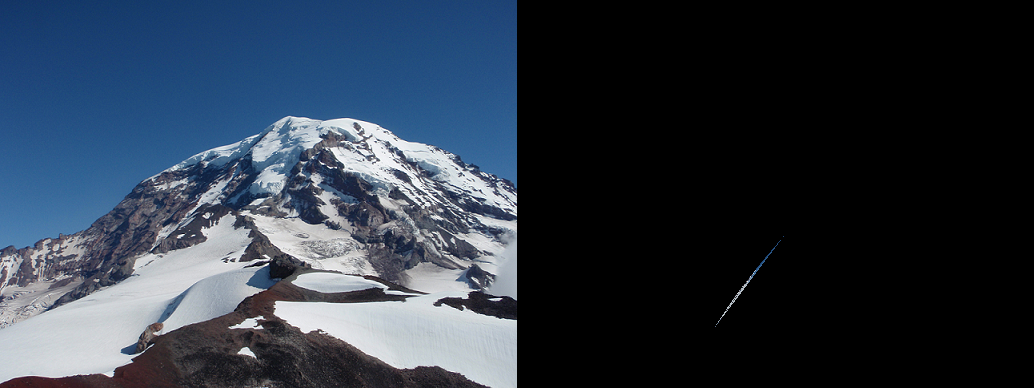

In [200]:
im1 = Image.open('../data/Rainier1.png').convert('RGB')
im2 = Image.open('../data/Rainier2.png').convert('RGB')
im12 = panorama_image(im1, im2, thresh=50)
display(im12)

I have tried multiple variations of code, but i have a mistake in the code, and i am not able to find it. I had some better results than this, but never the less it is not correct. I also used github copilot to comment some of my code for clarity when trying to debug/find the mistake. Sorry for the inconvenience.